# Monte Carlo Methods

In this notebook, I wrote my implementations of many Monte Carlo (MC) algorithms. 

I used good part of the starter code provided by Udacity and modified it or added my own code where necessary. I also include additional remarks and comments for easing the understanding of the code.

## Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

####  About defaultdict
A common problem that you can face when working with Python dictionaries is to try to access or modify keys that don’t exist in the dictionary. This will raise a KeyError and break up your code execution. To handle these kinds of situations, the standard library provides the Python defaultdict type, a dictionary-like class that’s available for you in collections. The Python defaultdict type behaves almost exactly like a regular Python dictionary, but if you try to access or modify a missing key, then defaultdict will automatically create the key and generate a default value for it. This makes defaultdict a valuable option for handling missing keys in dictionaries

In [30]:
import sys
import gym
import numpy as np
from collections import defaultdict    # See notes below
from plot_utils import plot_blackjack_values, plot_policy    # plot_utils.py is an auxiliary plotting function

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [31]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [32]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

The code currently plays Blackjack three times. The cell is designed to get some experience with the output that is returned as the agent interacts with the environment.

In [41]:
for i_episode in range(10):
    state = env.reset()
    while True:
        print('state:', state)
        action = env.action_space.sample()    # Random action
        print('action (0=stick; 1=hit):',action)
        state, reward, done, info = env.step(action)
        if done:
            print('Final state:',state)
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

state: (14, 8, False)
action (0=stick; 1=hit): 1
Final state: (24, 8, False)
End game! Reward:  -1
You lost :(

state: (13, 2, False)
action (0=stick; 1=hit): 0
Final state: (13, 2, False)
End game! Reward:  1.0
You won :)

state: (7, 7, False)
action (0=stick; 1=hit): 1
state: (15, 7, False)
action (0=stick; 1=hit): 0
Final state: (15, 7, False)
End game! Reward:  -1.0
You lost :(

state: (13, 3, False)
action (0=stick; 1=hit): 1
Final state: (22, 3, False)
End game! Reward:  -1
You lost :(

state: (20, 10, False)
action (0=stick; 1=hit): 0
Final state: (20, 10, False)
End game! Reward:  0.0
You lost :(

state: (6, 8, False)
action (0=stick; 1=hit): 0
Final state: (6, 8, False)
End game! Reward:  -1.0
You lost :(

state: (18, 5, False)
action (0=stick; 1=hit): 0
Final state: (18, 5, False)
End game! Reward:  1.0
You won :)

state: (5, 8, False)
action (0=stick; 1=hit): 0
Final state: (5, 8, False)
End game! Reward:  -1.0
You lost :(

state: (11, 2, False)
action (0=stick; 1=hit): 0
Fi

## Part 1: MC Prediction

In this section, I wrote my implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [34]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]  # definition of probabilities
        action = np.random.choice(np.arange(2), p=probs)     # selecting action acc. to defined probabilities
        next_state, reward, done, info = bj_env.step(action) # interaction with environment
        episode.append((state, action, reward))              # appending a tuple to the episode list
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

The code currently plays Blackjack three times. The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.

Note the output of the function,is a list of tuples.

In [45]:
for i in range(10):
    print(generate_episode_from_limit_stochastic(env))

[((14, 1, False), 1, 0), ((17, 1, False), 1, -1)]
[((18, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[((13, 4, False), 0, 1.0)]
[((11, 10, False), 1, 0), ((17, 10, False), 1, -1)]
[((16, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[((19, 2, False), 0, 1.0)]
[((12, 10, False), 1, -1)]
[((20, 7, False), 0, 1.0)]
[((12, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]
[((15, 5, False), 1, -1)]


Now my implementation of MC prediction.  Note that in the case of the Blackjack environment, either first-visit or every-visit MC prediction are equivalent. Therefore, every-visit is implemented for simplicity. Note the psecudocode for first-visit MC prediction algorithm below.

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

#### Pseudocode for first-visit MC prediction
<img src='images/FV-MC_Prediction.png'>

In [48]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    
    # initialize empty dictionaries of numpy arrays
    # note that 'defaultdict' is used to avoid potential 'key errors' when populating the dicts.
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()    # it writes everything in the buffer to the terminal (stylistic)
            
        # generation of one episode
        episode = generate_episode(env)
        
        # separating episode output (list of tuples) in single lists
        states, actions, rewards = zip(*episode)   
        
        # discounting factor
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        
        # Since in this blackjack environment, first-visit and every-visit give an
        # equivalent MC-prediction, every-visit is coded here for simplicity.
        #
        # The 'for' loop estimates and update the sum of the returns, number of visits and action-value
        # for each state-action pair in the episode 
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
        
    return Q

Cell below obtains the action-value function estimate $Q$ for the stochastic policy defined before. The corresponding state-value function is also plotted.
Run a good number of episodes.

Episode 500000/500000.

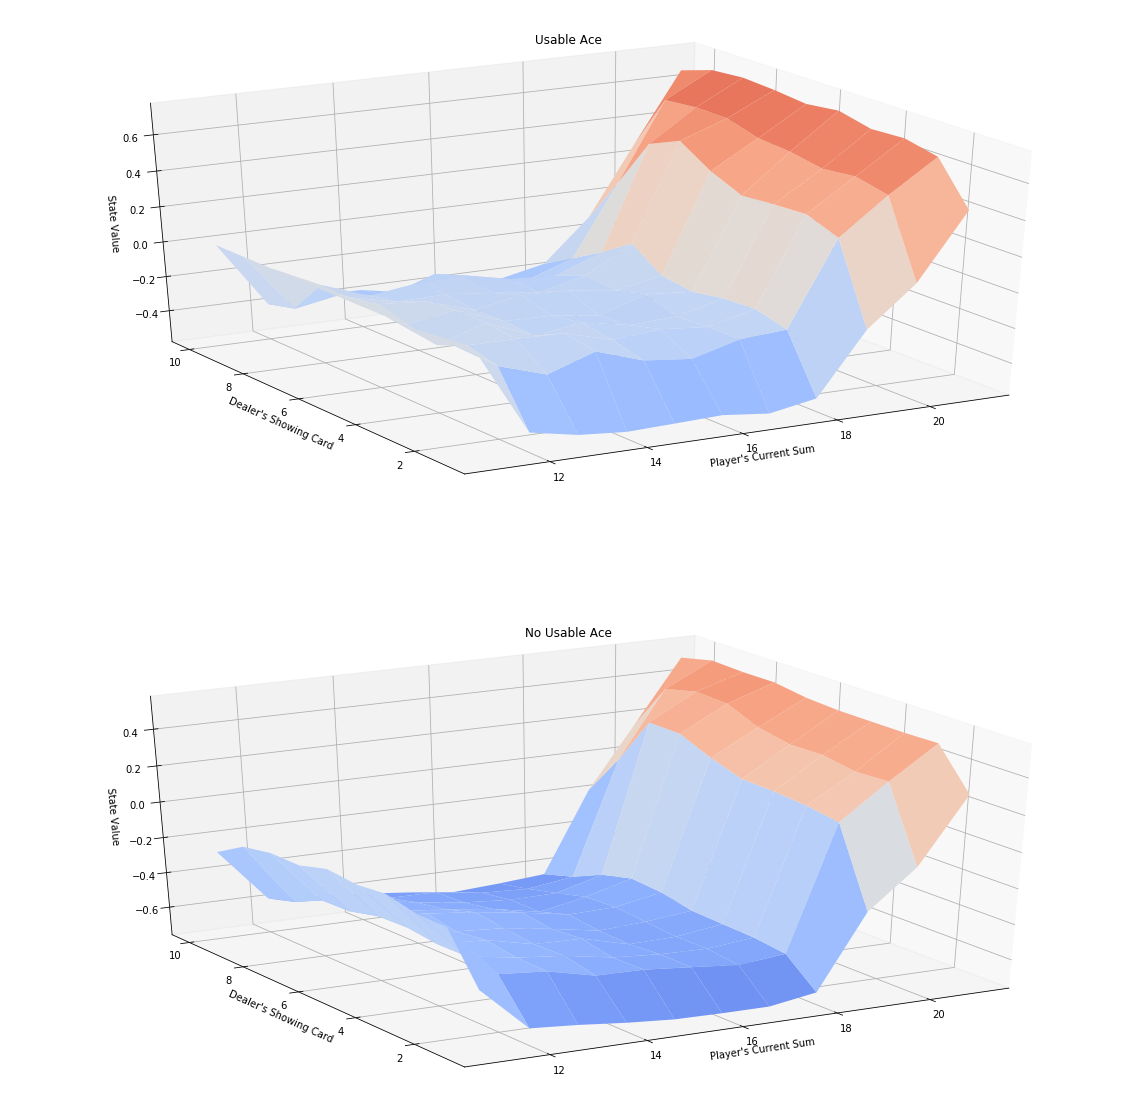

In [53]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

## Part 2: MC Control

In this section, I wrote my implementation of constant-$\alpha$ MC control. Note the psecudocode for first-visit constant-$\alpha$ MC control below. 

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.


#### Pseudocode for constant-α GLIE MC Control
<img src='images/FV_Constant-alpha_MC_Control.png'>

In [3]:
# Auxiliary functions to keep the code organized

def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
        # selection of action acc. to e-greedy policy; if state is new, random policy used instead
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        
        next_state, reward, done, info = env.step(action)  # interaction with environment
        episode.append((state, action, reward))            # appending a tuple to the episode list
        
        state = next_state
        
        if done:
            break
    return episode


def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA      # prob for non-greedy action
    best_a = np.argmax(Q_s)                    # identification of best action in Q(s,a)
    
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)  # prob for greedy action (max Q(s,a))
    
    return policy_s


def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)   # unzip episode(list of tuples) in single lists
    
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    
    # Q-table update with constant alpha amendment to MC control problem
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
        
    return Q

In [21]:
# MC control with epsilon decay and constant alpha amendment

def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    
    # initialize variables
    nA = env.action_space.n                # get action space dimension
    Q = defaultdict(lambda: np.zeros(nA))  # empty dictionary of arrays for Q-table
    epsilon = eps_start                    # epsilon for e-greedy policy
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # set the value of epsilon
        # decay and lower limit applied to reduce but always keep some exploration during action selection
        epsilon = max(epsilon*eps_decay, eps_min)
        
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
        
    # determine the improved policy corresponding to the final action-value function estimate Q-Table
    # the action giving the maximum action-value is picked for every state in the Q-table
    # policy is a dictionary with key=state and value=best action
    policy = dict((k,np.argmax(v)) for k, v in Q.items()) # argmax returns the index of the max value in the action list
    
    return policy, Q

The cell below obtains the estimated optimal policy and action-value function.

Fill in the values for the `num_episodes` and `alpha` parameters for getting different approximations.

In [50]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 1000000, 0.008)

Episode 1000000/1000000.

Next, we plot the corresponding state-value function.

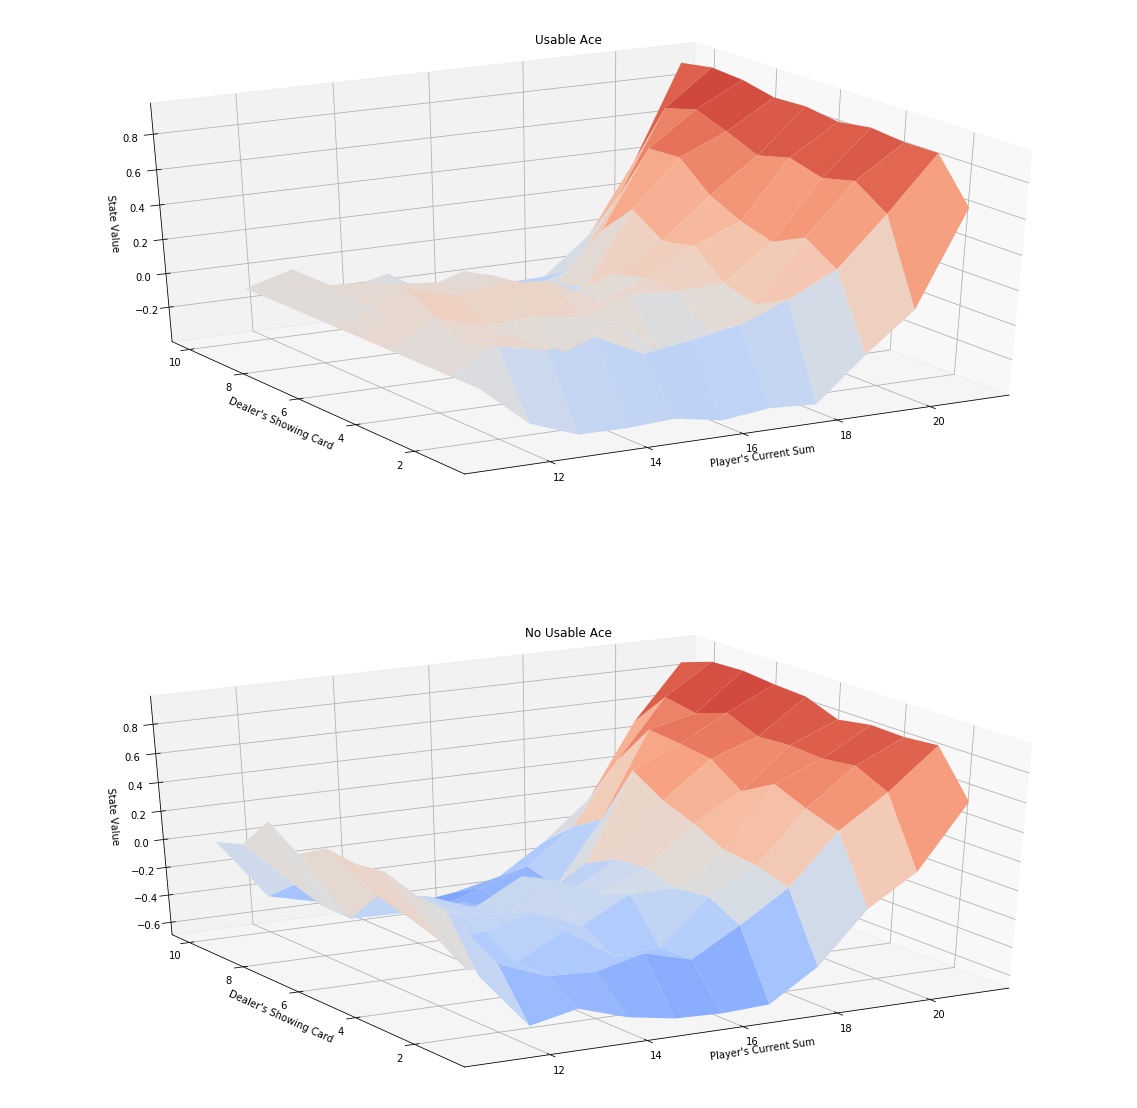

In [51]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

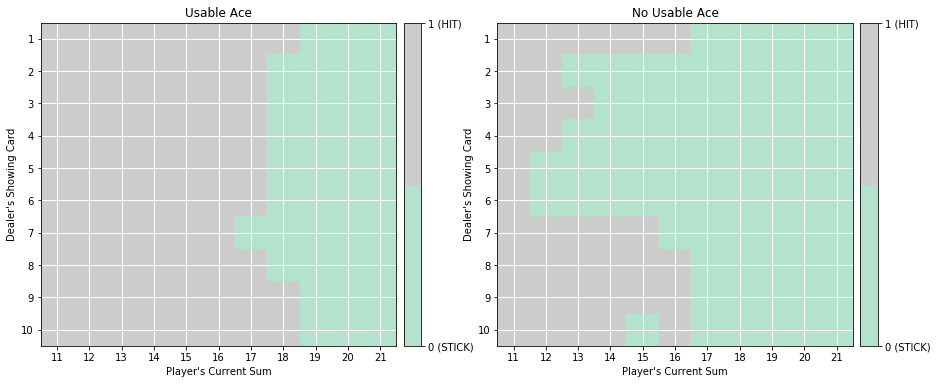

In [52]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare the final estimate obtained to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)

#### The final policy in action
Next we can see in action the final policy obtained. Compare its performance with the random one or the stochastic policy used before in this jupyter notebool. 

For 20 games, random performance (won games) is roughly 10%, 80-20 stochastics policy is roughly 20-30% and the obtained final policy is roughly 50%.

In [53]:
def generate_episode_from_final_estimate_policy(env, policy):
    episode = []
    state = env.reset()
    while True:
        action = policy[state]     # selecting action acc. to defined probabilities
        next_state, reward, done, info = env.step(action) # interaction with environment
        episode.append((state, action, reward))              # appending a tuple to the episode list
        state = next_state
        if done:
            break
    return episode

In [54]:
for i in range(10):
    print(generate_episode_from_final_estimate_policy(env, policy))

[((21, 1, True), 0, 1.0)]
[((17, 9, False), 0, -1.0)]
[((20, 2, False), 0, 1.0)]
[((5, 3, False), 1, 0), ((16, 3, True), 1, 0), ((16, 3, False), 0, -1.0)]
[((10, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[((15, 2, False), 0, -1.0)]
[((14, 1, False), 1, 0), ((18, 1, False), 0, -1.0)]
[((19, 10, False), 0, 1.0)]
[((21, 2, True), 0, 1.0)]
[((13, 2, False), 0, -1.0)]
